1. **Nome(s): Jordano Furtado de Souza, Felipe Sala Carpes, Marcos Vinícius Silva**
2. **Email : jordano.souza@edu.ufes.br, felipe.carpes@edu.ufes.br, marcos.s.silva@edu.ufes.br**
3. **Matrícula(s): 2022101183, 2022102425, 2020100954**
4. **Curso(s): Engenharia de Computação**

# Projeto Final - Ciência de Dados
# 1. Introdução

A disciplina de Ciência de Dados revelou, ao longo do curso, como um instrumento poderoso de interpretação da realidade. Percebemos que sua essência não está apenas na execução de algoritmos, mas na capacidade de usar os dados para compreender eventos e qualificar tomadas de decisões. Como aplicação direta desse conhecimento, este trabalho explora dados do varejo online no Brasil para responder a uma questão de negócio fundamental: o que determina a satisfação do cliente em relação à entrega? Através da modelagem preditiva, buscamos mensurar o peso de diferentes variáveis logísticas na percepção de valor do consumidor.


# 2. Definição do Problema

O problema central abordado neste projeto é a predição da satisfação do consumidor baseada estritamente nas métricas de entrega. Utilizando um dataset de transações digitais, buscamos correlacionar as variáveis do processo logístico com a nota de avaliação (rating) concedida pelo cliente. O estudo foca em identificar padrões em dados como tempo de deslocamento, custos de envio e cumprimento de prazos, a fim de determinar quais dessas características logísticas são as mais críticas. A finalidade é construir um modelo que, a partir dos dados do delivery, consiga antecipar se o serviço resultará em uma boa ou má avaliação.

# 3. Descrição do Conjunto de Dados

Para a realização deste estudo, utilizou-se o Brazilian E-Commerce Public Dataset, disponibilizado pela Olist na plataforma Kaggle. Trata-se de um conjunto de dados reais e anonimizados que compreende aproximadamente 100 mil pedidos realizados em diversos marketplaces no Brasil, abrangendo o período de 2016 a 2018. A base de dados apresenta uma estrutura relacional composta por múltiplas tabelas interconectadas, permitindo uma visão holística de todo o processo de venda: desde a realização do pedido e o pagamento, passando pelas características físicas do produto e logística de frete, até a entrega final e a avaliação (review) do consumidor.

# 4. Metodologia

## 4.1 Processamento dos Dados

O primeiro passo para resolver o problema proposto foi o processamento das diversas tabelas originais para a criação de uma estrutura única, a 'Tabela Mestre'. Inicialmente, realizamos uma limpeza nos dados, filtrando e mantendo apenas as informações que realmente seriam impactantes para o nosso resultado final. Além da seleção, focamos no cálculo de novas métricas a partir das informações existentes e na agregação dos itens, garantindo que todos os dados relevantes estivessem centralizados. Todos esses passos de tratamento e unificação das tabelas serão detalhados a seguir.

### 4.1.1 Tabela de Pedidos (`orders_dataset`)

O objetivo dessa etapa é converter instantes temporais em intervalos de tempo, que possuem maior poder preditivo para o nosso classificador de satisfação. As métricas geradas são:
1. **Tempo de Entrega Real**: O período total que o cliente esperou pelo produto.
2. **Tempo de Delay (Atraso)**: A diferença entre a promessa de entrega e a realidade (valores positivos indicam atraso).
3. **Tempo de Despache**: Eficiência do vendedor e da logística interna até a entrega para a transportadora.


In [2]:
import pandas as pd
import numpy as np

# Configuração para visualizar todas as colunas
pd.set_option('display.max_columns', None)

In [3]:
# carregar dataset
df_orders = pd.read_csv('dataset/raw/orders_dataset.csv')

# remover pedidos que ainda não foram entregues
df_orders = df_orders[df_orders['order_status'] == 'delivered'].copy()

In [4]:
# conversão de string para datetime
cols_date = [
    'order_purchase_timestamp', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date'
]
for col in cols_date:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [5]:
# transformação de tempo em dias
df_orders['tempo_entrega_real'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.total_seconds() / 86400
df_orders['tempo_delay'] = (df_orders['order_delivered_customer_date'] - df_orders['order_estimated_delivery_date']).dt.total_seconds() / 86400
df_orders['tempo_despache'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_approved_at']).dt.total_seconds() / 86400
# df_orders[['tempo_entrega_real', 'tempo_delay', 'tempo_despache']].head()

In [6]:
# colunas finais referente a losgistica das entrehgas
colunas_finais = [
    'order_id', 
    'customer_id', 
    'order_purchase_timestamp',  # Mantendo a referência temporal
    'tempo_entrega_real', 
    'tempo_delay', 
    'tempo_despache'
]
# salvando tabela
df_final_time = df_orders[colunas_finais].copy()

# Visualizar o resultado
df_final_time.head()

,order_id,customer_id,order_purchase_timestamp,tempo_entrega_real,tempo_delay,tempo_despache
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,8.436574,-7.107488,2.366493
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,13.782037,-5.355729,0.462882
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,9.394213,-17.245498,0.204595
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,13.208750,-12.980069,3.745833
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2.873877,-9.238171,0.893113


### 4.1.2 Tabela de Produtos (products_dataset)

O objetivo desta etapa é extrair características físicas e de categoria que possam influenciar a expectativa do cliente. 
As métricas geradas são:
1. **Volume do Produto**: Calculado a partir das dimensões (comprimento × altura × largura).
2. **Densidade do Produto**: Relação entre peso e volume, útil para identificar produtos frágeis ou muito robustos.
3. **Nível de Detalhamento**: Comprimento da descrição e nome do produto.

In [7]:
# carregar dataset
df_prod = pd.read_csv('dataset/raw/products_dataset.csv')

In [8]:
# calculo volume
df_prod['product_volume_cm3'] = (
    df_prod['product_length_cm'] * df_prod['product_height_cm'] * df_prod['product_width_cm']
)

# Tratando volume 0 para evitar erro na densidade
df_prod['product_volume_cm3'] = df_prod['product_volume_cm3'].replace(0, np.nan)

# calculo densidade
df_prod['product_density'] = df_prod['product_weight_g'] / df_prod['product_volume_cm3']

# preenchimento de valores não preenchidos
cols_fix = ['product_description_lenght', 'product_name_lenght', 'product_photos_qty', 'product_density', 'product_volume_cm3']
for col in cols_fix:
    df_prod[col] = df_prod[col].fillna(0)

In [9]:
# configuração final
df_final_products = df_prod[[
    'product_id', 
    'product_volume_cm3', 
    'product_density', 
    'product_description_lenght', 
    'product_photos_qty'
]].copy()

# Visualizar o resultado
df_final_products.head(10)

,product_id,product_volume_cm3,product_density,product_description_lenght,product_photos_qty
0,1e9e8ef04dbcff4541ed26657ea517e5,2240.0,0.100446,287.0,1.0
1,3aa071139cb16b67ca9e5dea641aaa2f,10800.0,0.092593,276.0,1.0
2,96bd76ec8810374ed1b65e291975717f,2430.0,0.063374,250.0,1.0
3,cef67bcfe19066a932b7673e239eb23d,2704.0,0.137204,261.0,1.0
4,9dc1a7de274444849c219cff195d0b71,4420.0,0.141403,402.0,4.0
5,41d3672d4792049fa1779bb35283ed13,2090.0,0.095694,745.0,1.0
6,732bd381ad09e530fe0a5f457d81becb,73920.0,0.248241,1272.0,4.0
7,2548af3e6e77a690cf3eb6368e9ab61e,12800.0,0.070312,184.0,2.0
8,37cc742be07708b53a98702e77a21a02,5967.0,0.067035,163.0,1.0
9,8c92109888e8cdf9d66dc7e463025574,2040.0,0.294118,1156.0,1.0


### 4.1.3 Tabela de Itens (`order_items_dataset`)

O objetivo desta etapa foi analisar as características financeiras das transações, determinando o custo total pago pelo cliente. O processamento consistiu no agrupamento de todos os itens de um mesmo pedido para calcular os valores consolidados de preço e frete.

As métricas geradas são:
1. **Valor Total do Pedido**: Soma dos preços de todos os itens do pedido.
2. **Valor Total do Frete**: Custos logísticos totais acumulados.
3. **Quantidade de Itens**: Número total de produtos no carrinho.
4. **Ratio Frete/Produto**: Razão entre frete e valor dos itens.
5. **Ticket Médio por Item**: Pedidos com itens caros tendem a gerar maior ansiedade no cliente

In [10]:
# carregar dataset
df_items = pd.read_csv('dataset/raw/order_items_dataset.csv')

# unir itens com a tabelas de produtos
df_items_enriquecido = df_items.merge(df_final_products, on='product_id', how='left')

In [11]:
# agrupamento por pedido
df_final_price = df_items_enriquecido.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
    'order_item_id': 'count',
    'product_volume_cm3': 'mean',
    'product_density': 'mean',
    'product_description_lenght': 'mean',
}).reset_index()

In [12]:
# ajustando nome colunas
df_final_price.columns = [
    'order_id', 'vl_total_pedido', 'vl_frete_total', 'qtd_itens', 
    'avg_volume', 'avg_density', 'avg_description_len'
]
# nova feature de proporcionalidade, entre o valor do pedido com o frete 
df_final_price['ratio_frete_produto'] = df_final_price['vl_frete_total'] / df_final_price['vl_total_pedido']

# nova feature de preço médio do produto, identifica se foi uma compra de produtos caros ou muitos produtos
df_final_price['ticket_medio_item'] = df_final_price['vl_total_pedido'] / df_final_price['qtd_itens']

# Visualizar o resultado
df_final_price.head(10)

,order_id,vl_total_pedido,vl_frete_total,qtd_itens,avg_volume,avg_density,avg_description_len,ratio_frete_produto,ticket_medio_item
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,1,3528.0,0.184240,598.0,0.225637,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,1,60000.0,0.500000,239.0,0.083076,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,1,14157.0,0.215441,695.0,0.089799,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,1,2400.0,0.083333,480.0,0.984604,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,1,42000.0,0.089286,409.0,0.090745,199.90
5,00048cc3ae777c65dbb7d2a0634bc1ea,21.90,12.69,1,2880.0,0.156250,558.0,0.579452,21.90
6,00054e8431b9d7675808bcb819fb4a32,19.90,11.85,1,2700.0,0.074074,815.0,0.595477,19.90
7,000576fe39319847cbb9d288c5617fa6,810.00,70.75,1,118125.0,0.116868,1310.0,0.087346,810.00
8,0005a1a1728c9d785b8e2b08b904576c,145.95,11.65,1,5760.0,0.347222,493.0,0.079822,145.95
9,0005f50442cb953dcd1d21e1fb923495,53.99,11.40,1,1827.0,0.465244,1192.0,0.211150,53.99


### 4.1.4 Tabela de Clientes (customers_dataset)

O objetivo desta etapa é extrair a localização do consumidor.

In [13]:
# carregar o dataset
df_customers = pd.read_csv('dataset/raw/customers_dataset.csv')

cols_customers = [
    'customer_id',
    'customer_city',
    'customer_state'
]

In [14]:
df_customers = df_customers[cols_customers].copy()

# padronizar a escrita
df_customers['customer_city'] = df_customers['customer_city'].str.upper()
df_customers['customer_state'] = df_customers['customer_state'].str.upper()

# salvando tabela, só as colunas importantes
df_final_costumers = df_customers.copy()

# Visualizar o resultado
df_final_costumers.head()

,customer_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,FRANCA,SP
1,18955e83d337fd6b2def6b18a428ac77,SAO BERNARDO DO CAMPO,SP
2,4e7b3e00288586ebd08712fdd0374a03,SAO PAULO,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,MOGI DAS CRUZES,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,CAMPINAS,SP


### 4.1.5 Tabela de Avaliações (order_reviews_dataset)

O alvo do nosso trabalho.

- Classe 0 (Insatisfeito): Notas 1, 2 e 3.
- Classe 1 (Satisfeito): Notas 4 e 5.

In [15]:
# carregar o dataset
df_reviews = pd.read_csv('dataset/raw/order_reviews_dataset.csv')

In [16]:
def binarizar_nota(score):
    if score >= 4:
        return 1 # Satisfeito
    else:
        return 0 # Insatisfeito

In [17]:
df_reviews['target_label'] = df_reviews['review_score'].apply(binarizar_nota)
df_final_reviews = df_reviews[['order_id', 'review_score', 'target_label']].copy()
df_final_reviews.head()

,order_id,review_score,target_label
0,73fc7af87114b39712e6da79b0a377eb,4,1
1,a548910a1c6147796b98fdf73dbeba33,5,1
2,f9e4b658b201a9f2ecdecbb34bed034b,5,1
3,658677c97b385a9be170737859d3511b,5,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,1


### 4.1.6 Construção Tabela Final 

O objetivo deste trecho é unificar as informações processadas de avaliações, logística, preços e clientes em um único dataset consolidado (Tabela Mestre), removendo registros incompletos e criando um indicador binário de atraso para deixar os dados prontos para a modelagem.

In [18]:
# Iniciando o merge a partir dos reviews (base do target)
df_master = df_final_reviews.copy()

# Join com Logística
df_master = df_master.merge(df_final_time, on='order_id', how='left')

# Join com Preços e Produtos 
df_master = df_master.merge(df_final_price, on='order_id', how='left')

# Join com Clientes 
df_master = df_master.merge(df_final_costumers, on='customer_id', how='left')

In [19]:
# Limpeza final de registros incompletos
df_master = df_master.dropna()

# Adicionando Flag de Atraso Binário
df_master['is_late'] = (df_master['tempo_delay'] > 0).astype(int)

print(f"Dataset Final: {df_master.shape}")


Dataset Final: (96992, 19)


In [20]:
# Dicionário de tradução e padronização
colunas_portugues = {
    'order_id': 'id_pedido',
    'customer_id': 'id_cliente',
    'review_score': 'nota_avaliacao',
    'target_label': 'alvo_insatisfacao',
    'order_purchase_timestamp': 'data_compra',
    'tempo_entrega_real': 'tempo_entrega_dias',
    'tempo_delay': 'atraso_estimado_dias',
    'tempo_despache': 'tempo_postagem_vendedor_dias',
    'vl_total_pedido': 'valor_total_pedido',
    'vl_frete_total': 'valor_frete_total',
    'qtd_itens': 'quantidade_itens',
    'avg_volume': 'volume_medio_cm3',
    'avg_density': 'densidade_media_gcm3',
    'avg_desc_len': 'tamanho_medio_descricao',
    'ratio_frete_produto': 'proporcao_frete_produto',
    'ticket_medio_item': 'valor_medio_por_item',
    'customer_zip_code_prefix': 'cep_prefixo_cliente',
    'customer_city': 'cidade_cliente',
    'customer_state': 'uf_cliente',
    'is_late': 'indicador_atraso'
}

# Aplicando a renomeação
df_master = df_master.rename(columns=colunas_portugues)

df_master.to_csv('dataset/processed/tabela_combinada_versao_1.csv', index=False)

# Verificando o resultado
print(df_master.columns.tolist())

['id_pedido', 'nota_avaliacao', 'alvo_insatisfacao', 'id_cliente', 'data_compra', 'tempo_entrega_dias', 'atraso_estimado_dias', 'tempo_postagem_vendedor_dias', 'valor_total_pedido', 'valor_frete_total', 'quantidade_itens', 'volume_medio_cm3', 'densidade_media_gcm3', 'avg_description_len', 'proporcao_frete_produto', 'valor_medio_por_item', 'cidade_cliente', 'uf_cliente', 'indicador_atraso']


Esta tabela serve como referência técnica para entender cada variável (feature) que o classificador utilizará para prever a satisfação do cliente.

| Coluna | Descrição |
| :--- | :--- |
| **id_pedido** | Identificador único do pedido. |
| **id_cliente** | Identificador do cliente associado ao pedido. |
| **nota_avaliacao** | Pontuação de satisfação dada pelo usuário (1 a 5). |
| **alvo_insatisfacao** | **Target (Variável Alvo)**: 1 para Satisfeito (notas 4 e 5) e 0 para Insatisfeito (notas 1, 2 e 3). |
| **data_compra** | Carimbo de data e hora de quando o pedido foi realizado. |
| **tempo_entrega_dias** | Tempo total (em dias) desde a compra até a entrega efetiva ao cliente. |
| **atraso_estimado_dias** | Diferença entre a entrega real e a estimativa inicial (valores positivos indicam atraso). |
| **tempo_postagem_vendedor_dias** | Tempo que o vendedor levou para despachar o produto após a aprovação do pedido. |
| **valor_total_pedido** | Valor total da soma dos preços de todos os itens do pedido. |
| **valor_frete_total** | Valor total acumulado do frete para o pedido. |
| **quantidade_itens** | Número total de itens inclusos no mesmo pedido. |
| **volume_medio_cm3** | Média do volume físico (C x A x L) dos produtos que compõem o pedido. |
| **densidade_media_gcm3** | Média da densidade (peso/volume) dos produtos comprados. |
| **tamanho_medio_descricao** | Média da quantidade de caracteres na descrição técnica dos produtos. |
| **proporcao_frete_produto** | Razão entre o custo do frete e o valor total do produto (sensibilidade ao preço). |
| **valor_medio_por_item** | Valor médio (ticket médio) de cada item individual no pedido. |
| **cidade_cliente** | Nome da cidade de destino da entrega. |
| **uf_cliente** | Estado (Unidade da Federação) do comprador. |
| **indicador_atraso** | Flag binária: 1 se houve atraso em relação à estimativa, 0 caso contrário. |

In [21]:
# Testes básicos antes de iniciar o processo do classificador

# Contagem absoluta
print("Distribuição das Classes:")
print(df_master['alvo_insatisfacao'].value_counts())

# Contagem percentual
print("\nPercentual das Classes:")
print(df_master['alvo_insatisfacao'].value_counts(normalize=True) * 100)

cols_analise = ['tempo_entrega_dias', 'atraso_estimado_dias', 'valor_total_pedido', 'proporcao_frete_produto']
display(df_master[cols_analise].describe())

# Calculando a correlação apenas das colunas numéricas com o alvo
correlacoes = df_master.corr(numeric_only=True)['alvo_insatisfacao'].sort_values(ascending=False)

print("Correlação das variáveis com a Satisfação do Cliente:")
print(correlacoes)

Distribuição das Classes:
alvo_insatisfacao
1    76170
0    20822
Name: count, dtype: int64

Percentual das Classes:
alvo_insatisfacao
1    78.53225
0    21.46775
Name: proportion, dtype: float64


,tempo_entrega_dias,atraso_estimado_dias,valor_total_pedido,proporcao_frete_produto
count,96992.000000,96992.000000,96992.000000,96992.000000
mean,12.564054,-11.181226,136.897884,0.308562
std,9.542185,10.184474,208.714371,0.311539
min,0.533414,-146.016123,0.850000,0.000000
25%,6.771056,-16.244314,45.900000,0.132117
50%,10.224144,-11.948536,86.000000,0.224430
75%,15.732433,-6.391869,149.900000,0.380845
max,209.628611,188.975081,13440.000000,21.447059


Correlação das variáveis com a Satisfação do Cliente:
alvo_insatisfacao               1.000000
nota_avaliacao                  0.896701
avg_description_len             0.016619
densidade_media_gcm3            0.001259
valor_medio_por_item           -0.000372
proporcao_frete_produto        -0.022653
volume_medio_cm3               -0.023594
valor_total_pedido             -0.027046
valor_frete_total              -0.080693
quantidade_itens               -0.111665
tempo_postagem_vendedor_dias   -0.137569
atraso_estimado_dias           -0.235312
tempo_entrega_dias             -0.293894
indicador_atraso               -0.321770
Name: alvo_insatisfacao, dtype: float64


## 4.2 Análise de Importância e Seleção de Variáveis

O próximo passo deste estudo foi realizar uma análise investigativa sobre as variáveis disponíveis. Com a tabela mestre já consolidada, precisávamos entender, antes de qualquer modelagem, quais características exerciam maior influência sobre a satisfação do cliente. Por isso, dedicamos esta etapa a mensurar estatisticamente o 'peso' de cada informação (como atraso, preço ou frete), garantindo que o modelo final focasse apenas no que realmente importa.

### 4.2.1 Preparação e Divisão dos Dados (Treino e Teste)
Inicialmente, realizamos uma limpeza final removendo colunas que não possuem valor preditivo para o modelo, como identificadores únicos (id_pedido, id_cliente) e dados textuais de localização (uf, cidade), que poderiam gerar ruído na função de cálculo de importância.

Em seguida, aplicamos a separação do conjunto de dados. Essa etapa é crucial para garantir a integridade do estudo: a seleção de variáveis e o treinamento devem ser feitos apenas no conjunto de Treino, reservando o conjunto de Teste exclusivamente para a validação final.

In [22]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#removendo colunas que não são relevantes
cols_to_drop = ['uf_cliente', 'cidade_cliente', 'id_pedido', 'id_cliente', 'data_compra']
X = df_master.drop(columns= cols_to_drop + ['nota_avaliacao', 'alvo_insatisfacao'])
y = df_master['alvo_insatisfacao']

#separacao treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


### 4.2.2 Cálculo de Informação Mútua

Para verificar as características mais importantes, aplicamos o conceito de Informação Mútua (Mutual Information). Este método estatístico mede a dependência entre duas variáveis, ou seja, quanta informação a presença de uma característica (ex: atraso) nos dá sobre a classe alvo (satisfação).

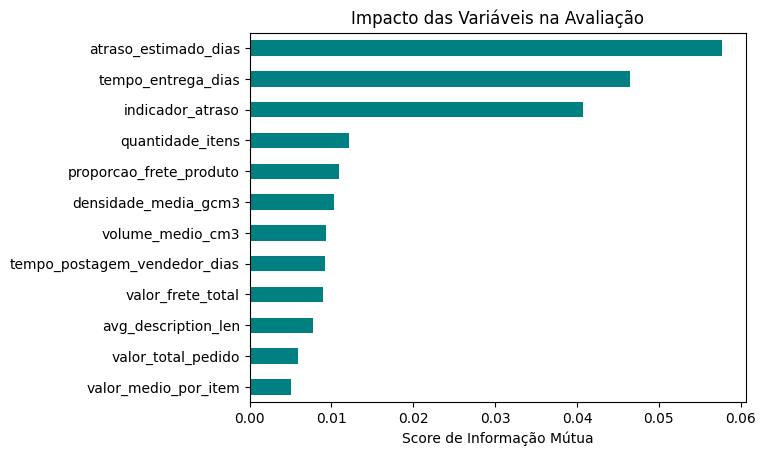

In [23]:
# 3. Calcular Informação Mútua
importances = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

# 4. Visualização
feature_importances = pd.Series(importances, index=X_train.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', color='teal')
plt.title('Impacto das Variáveis na Avaliação')
plt.xlabel('Score de Informação Mútua')
plt.show()

### 4.2.3 Seleção das Melhores Características (K-Best)

Com os resultados obtidos pela análise gráfica acima, observamos que a relevância decai rapidamente após as primeiras variáveis. Vale ressaltar que a maior concentração de informação está nas três primeiras características (geralmente relacionadas a atraso e tempo de entrega).

Dessa forma, optamos por reduzir a dimensionalidade do modelo selecionando apenas as 7 características (features) mais importantes. A influência das variáveis restantes mostrou-se marginal, e sua remoção ajuda a simplificar o modelo sem perda significativa de poder preditivo.

In [24]:
from sklearn.feature_selection import SelectKBest

#verificando as K caricteristicas mais importantes
ms = SelectKBest(score_func = mutual_info_classif, k = 7)
ms.fit(X_train, y_train);

ms.set_output(transform = 'pandas')
ms.transform(X)

,tempo_entrega_dias,atraso_estimado_dias,valor_frete_total,quantidade_itens,volume_medio_cm3,proporcao_frete_produto,indicador_atraso
0,6.133241,-15.220359,27.26,2.0,31500.0,0.073676,0
1,9.452789,-4.029630,8.30,1.0,3724.0,0.104023,0
2,13.314190,-20.271667,45.12,1.0,8000.0,0.302819,0
3,10.644005,-19.619039,42.85,1.0,8000.0,0.238069,0
4,18.232315,-8.310012,134.25,1.0,183750.0,0.111968,0
...,...,...,...,...,...,...,...
99995,4.815012,-11.278472,9.77,1.0,11799.0,0.048852,0
99996,3.327650,-15.261019,15.59,1.0,42920.0,0.072186,0
99997,7.840544,-15.459826,15.46,1.0,1760.0,0.303435,0
99998,4.138970,-14.080208,7.78,1.0,4500.0,0.778000,0


## 4.3 Modelo preditivo com Florestas Aleatórias
Para o treinamento do modelo, iremos utilizar uma combinação de árvores de decisão(floresta aleatória). A escolha desse algoritmo de classificação se dá devido a sua robustez para identificar uma correlação, entre variáveis, não linear. Nesse caso, estaremos observando como a nota do pedido se comporta mediante algumas variáveis(vide tabela x) com o objetivo de prever como um produto será avaliado.

Para criar um bom modelo precisamos que, dado um conjunto de dados, ele possua alta probabilidade de acerto e, concomitantemente, seja generalizável.

Inicialmente, testemos um modelo "cru" de florestas aleatórias fornecidos pela scikitlearn:

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train);

In [26]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.25      0.37      5218
           1       0.83      0.97      0.89     19030

    accuracy                           0.82     24248
   macro avg       0.77      0.61      0.63     24248
weighted avg       0.80      0.82      0.78     24248



Apesar de ter uma boa acurácia de 82%, com esse relatório podemos ver que o conjunto de dados é bem desbalanceado com relação a quantidade de classes tidas como "0" e "1".  A métrica "recall" nos diz que de todos os exemplos que realmente eram classe "0" o modelo só encontrou 25%.
Caso fizéssemos um classificador que chuta 1 como resposta ele apresentaria 78% de precisão, o que é ligeiramente menor do que o nosso resultado.

Para tentar resolver esse problema vamos utilizar o algoritmo de boosting (AdaBoost na scikitlearn).
Diferente da abordagem paralela do Random Forest, o AdaBoost treina classificadores fracos (geralmente árvores de baixa profundidade) de maneira sequencial.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
import sklearn.tree as tree

ada = AdaBoostClassifier(tree.DecisionTreeClassifier(), n_estimators = 100)

ada.fit(X_train, y_train)

#pega somente a coluna da probabilidade de pertencer a classe 1
y_proba_satisfeito = ada.predict_proba(X_test)[:, 1]

threshold = 0.70

#define como zero os valore que são inferiores a 70%
y_pred_ajustado = (y_proba_satisfeito >= threshold).astype(int)

print(classification_report(y_test, y_pred_ajustado))

O resultado é relativamente satisfatório(recall de 54%) para este caso, em específico, no qual prever um falso positivo não necessariamente tem um custo tão alto para nós. No entanto, aumentar a penalização por falsos positivos reduz significamente a precisão do modelo.

# 5. Conclusão

## Link Video: